# Annotated visualisations of longevity abstracts for AIIM publication

In [1]:
%load_ext autoreload
%autoreload 2

## Load data

In [33]:
import pandas as pd

df = pd.read_pickle('data/pubmed_longevity.pkl')
len_before = len(df)

df = df[df["abstract"].str.len() >= 100]
f"Dokument kept: {len(df)}/{len_before}"

'Dokument kept: 16778/16791'

## Preprocess and compute embeddings

In [6]:
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from lemmagen.lemmatizer import Lemmatizer
from lemmagen import DICTIONARY_ENGLISH
from textsemantics import specific_words


nltk.download('stopwords', quiet=True)
lemmatizer = Lemmatizer(dictionary=DICTIONARY_ENGLISH)
stop_words = set(stopwords.words('english'))

def preprocess(corpus):
    tokenizer = RegexpTokenizer("\w+")
    preprocessed = list()
    for text in corpus:
        text = text.translate(text.maketrans('', '', string.punctuation))
        tokens = tokenizer.tokenize(text.lower())
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words 
                  and len(token) > 2 and not token.isnumeric()]

        tokens = list(filter(lambda a: a != '', tokens))  
        preprocessed.append(tokens)
    return preprocessed


abstracts = list(df['abstract'])
tokens_list = preprocess(abstracts)
doc_embs, word_embs, _, _ = specific_words.prepare_embeddings(tokens_list, 'en')

## Compute t-SNE embedding

In [8]:
%%time
from openTSNE import TSNE

tsne = TSNE(
    perplexity=500,
    initialization="pca",
    metric="cosine",
    n_jobs=2,
    random_state=0,
)

embedding_ = tsne.fit(doc_embs)

CPU times: user 8min 41s, sys: 5.82 s, total: 8min 47s
Wall time: 4min 35s


## Fucntion for clustering and visualisation

In [21]:
from orangecontrib.text.stats import hypergeom_p_values
from sklearn.feature_extraction.text import CountVectorizer
from Orange.statistics.util import FDR
import matplotlib.patheffects as path_effects
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter


CB_color_cycle = [
    '#377eb8', '#ff7f00', '#4daf4a',
    '#f781bf', '#a65628', '#984ea3',
     '#999999', '#e41a1c', '#dede00'
]


def take_first_n(kws, n):
    """ 
    Take first n without duplications which are present because of normaliztion
    in YAKE    
    """
    selected = []
    for kw in kws:
        if len(selected) >= n:
            break
        if kw not in selected:
            selected.append(kw)
    assert len(selected) <= n
    return selected
    

def hypergeom_clusters(points, labels, keywords, ax):
    num_kw = 20
    clusters = []
    lengths = []
    cl_labels = list(set(labels) - {-1})
    
    # gather keywords in list
    for i, cluster in enumerate(cl_labels):
        cluster_idx = np.where(labels == cluster)[0]
        clis = set(cluster_idx)
        all_kws = [
            take_first_n(kws, num_kw) for i, kws in enumerate(keywords) if i in clis
        ]
        lengths.append(len(all_kws))
        clusters += all_kws
    
    # count appearances
    def dummy(doc):
        return doc
    cv = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
    x = cv.fit_transform(clusters)
    features = np.array(cv.get_feature_names_out())
    
    start = 0
    for i, ll in enumerate(lengths):
        # find words that should be specific for a group with hypergeom test
        selected = x[start:start+ll]
        p_values = hypergeom_p_values(x, selected)
        fdr = FDR(p_values)
        assert len(features) == len(fdr)
        bellow_threshold = set(features[np.array(fdr) < 0.05].tolist())
        print(i, len(bellow_threshold))
        
        # use counts as measure but select only words which p-vales pass the threshold
        c = Counter([k for kws in clusters[start:start+ll] for k in kws])
        selected = []
        for el, _ in c.most_common():
            if len(selected) >= 5:
                break
            if el in bellow_threshold:
                selected.append(el)     
        
        start += ll 
        # plot
        cluster_idx = np.where(labels == cl_labels[i])[0]
        centroid = np.mean(points[cluster_idx, :], axis=0)
        ann = "\n".join(selected) + f'\n\n{i+1}'
        ax.text(centroid[0], centroid[1], ann,                 
                fontdict={'fontweight': 'bold', 'fontsize': 'xx-large'},
                va='center', ha='center')

        
def create_plot(kw, title='', label_method=hypergeom_clusters, sublinear_tf=False):

    estimator = GaussianMixture(n_components=8,
                covariance_type='full', max_iter=20, random_state=0)

    estimator.fit(embedding_)
    _, ax = plt.subplots(figsize=(12, 12))
    plt.style.use('seaborn')

    probs = estimator.predict_proba(embedding_)
    labels = np.argmax(probs, axis=1)
    max_probs = np.max(probs, axis=1)
    labels[max_probs < 0.6] = -1

    n_noise = list(labels).count(-1)
    #palette = sns.color_palette('colorblind', 8)
    palette = CB_color_cycle
    cs = [palette[l] if l > -1 else (0.5, 0.5, 0.5) for l in labels]
    s = [36 if l > -1 else 9 for l in labels]
    plt.scatter(embedding_[:, 0], embedding_[:, 1], c=cs,
                alpha=0.3, s=s);

    desc = label_method(embedding_, labels, kw, ax)

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_facecolor("white")

    return desc

## Visualisation with TF-IDF keywords

In [13]:
tfidf_kw = specific_words.tfidf_keywords(tokens=tokens_list)
tfidf_kw = [[x for x, _ in wds] for wds in tfidf_kw]

/home/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


/home/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 328
1 418
2 684
3 341
4 497
5 399
6 645
7 758


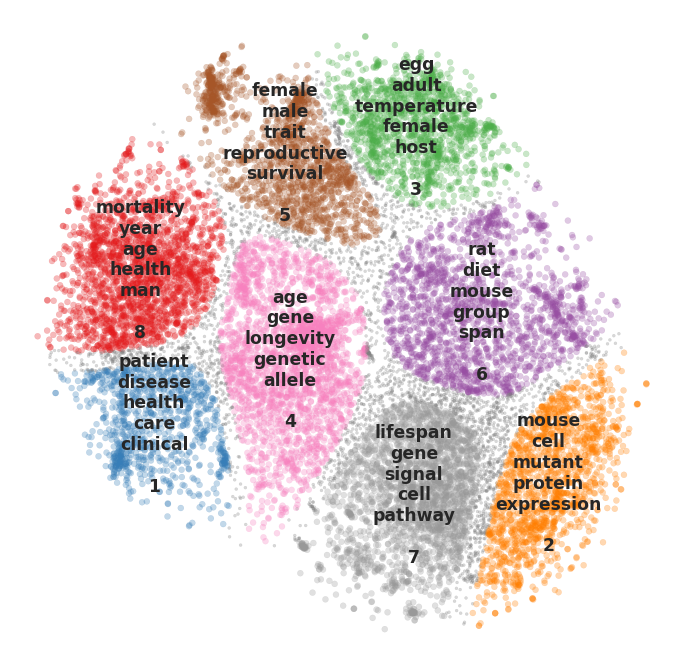

In [22]:
tfidf_desc = create_plot(tfidf_kw,  title='tf-idf - hyper', label_method=hypergeom_clusters)

## Visulaisation with YAKE keyowrds

In [23]:
%%time 
import yake

custom_kw_extractor = yake.KeywordExtractor(lan="en", n=1)
def yake_method(text):
    kw = custom_kw_extractor.extract_keywords(text)
    return [lemmatizer.lemmatize(x) for x, _ in kw if x not in stop_words]

yake_keywords = [yake_method(txt) for txt in df["abstract"]]

CPU times: user 10min 35s, sys: 1.28 s, total: 10min 37s
Wall time: 10min 35s


/home/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 258
1 421
2 791
3 230
4 356
5 313
6 405
7 542


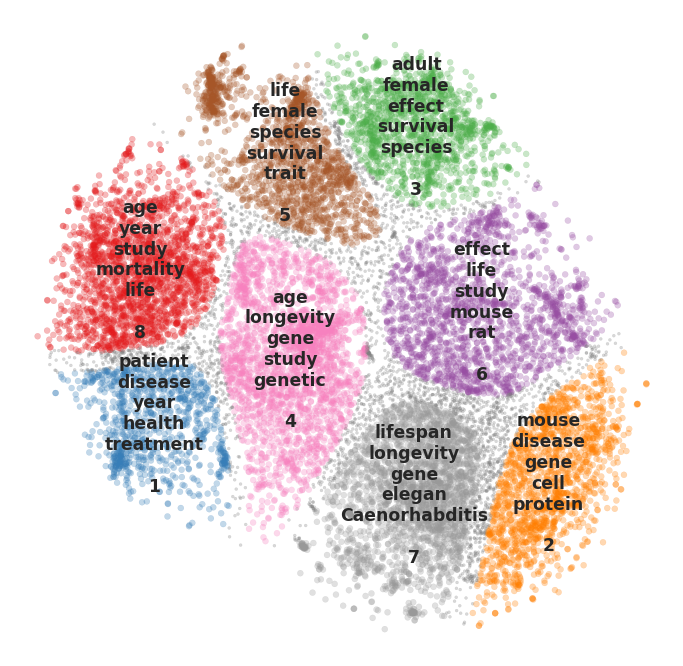

In [24]:
yake_desc = create_plot(yake_keywords, title='YAKE!-hyper', label_method=hypergeom_clusters)
# plt.savefig('document-map-yake-hyper.jpg', dpi=300)

## Visulaisation with Transformers keyowrds

In [27]:
from bert_keyword_extractor import TransformerKeywordExtractor

def get_kws(model_path):
    extractor = TransformerKeywordExtractor(model_path)
    _bert_keywords = extractor.extract_keywords(df['abstract'])
    bert_keywords = list()
    for kws in _bert_keywords:
        current = [lemmatizer.lemmatize(s) for w, _ in kws for s in w.split() if s not in stop_words]
        bert_keywords.append(list(set(current)))
    return bert_keywords
        
crosloengual_keywords = get_kws('models/crosloeng')

loading configuration file models/crosloeng/config.json
Model config BertConfig {
  "_name_or_path": "EMBEDDIA/crosloengual-bert",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "ner",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "B",
    "1": "I",
    "2": "O"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B": 0,
    "I": 1,
    "O": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.9.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 49601
}

Didn't find file models/crosloeng/added_tokens.json. We won't load it.
loading file models/crosloeng/vocab.txt
load

  0%|          | 0/19 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: tokens.
***** Running Prediction *****
  Num examples = 18110
  Batch size = 8


/home/primoz/text-semantics/examples/bert_keyword_extractor.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(predictions).to(self.device), dim=2)


/home/primoz/miniconda3/envs/text-semantics/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 51
1 85
2 207
3 27
4 82
5 72
6 121
7 109


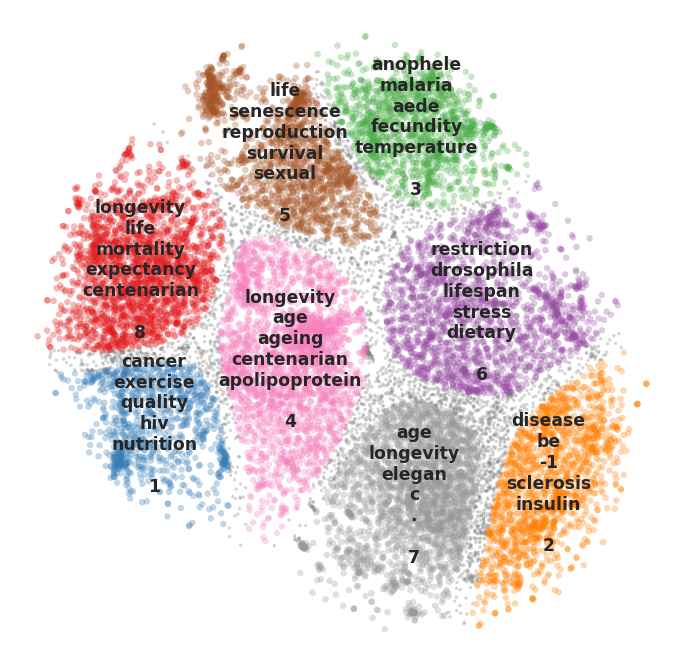

In [28]:
bert_desc = create_plot(crosloengual_keywords, title='BERT-hyper', label_method=hypergeom_clusters)